# Demo5: Reinforcement Learning with **Q-Learning** (Gridworld)

**Notebook link:** _

**Author:** 25034632

---



## 1. Problem & Objectives

**Problem:** Learn to navigate a 2D gridworld from a start state to a goal state while avoiding obstacles and penalties.  
This is a classic sequential decision-making task, naturally modelled as a **Markov Decision Process (MDP)**.

**MDP elements:**  
- **States (S):** Grid cells `(row, col)`; terminal when agent reaches Goal.  
- **Actions (A):** Up / Right / Down / Left.  
- **Transition (T):** Deterministic in this demo (bounded by walls).  
- **Reward (R):** Step penalty `-1`, obstacle penalty `-5`, goal reward `+10`.  
- **Discount (γ):** Weight of future rewards.

**Goal:** Learn an optimal **policy** π(s) that maximizes expected discounted return by estimating **Q(s,a)** values using **Q-Learning**.



## 2. How Q‑Learning Works (Technique Explanation)

Q‑Learning is an **off‑policy**, **model‑free** RL algorithm that learns an action‑value function **Q(s,a)** estimating the expected discounted return for taking action `a` in state `s` and following the **greedy** policy thereafter.

**Update rule (per step):**

\[ Q(s,a) \leftarrow Q(s,a) + \alpha \Big( r + \gamma \max_{a'} Q(s', a') - Q(s,a) \Big) \]

- **Inputs (from the problem):** states, actions, reward function, \(\gamma\).  
- **Initialization:** Q‑table zeros; set hyper‑parameters **α** (learning rate), **γ** (discount), **ε** (exploration).  
- **Loop (episodes):** For each episode, interact with environment:
  1. Choose action with **ε‑greedy** policy from Q (explore vs exploit).
  2. Observe next state and reward.
  3. Apply the Q‑update above.
  4. Optionally decay ε to reduce exploration over time.
- **Termination / Result:** After many episodes, derive the **greedy policy** `π(s) = argmax_a Q(s,a)` and evaluate it via rollouts.



## 3. Environment Setup (Gridworld)

**What this cell does:**  
- Defines a small grid with walls/obstacles, start, and goal.  
- Implements step transitions and rewards.  
- Provides helper utilities for visualisation and policy rollout.

**Key function (our environment):** `step(state, action)`  
- **Input:** current `state=(r,c)`, `action∈{0:Up,1:Right,2:Down,3:Left}`  
- **Output:** `next_state, reward, done`  


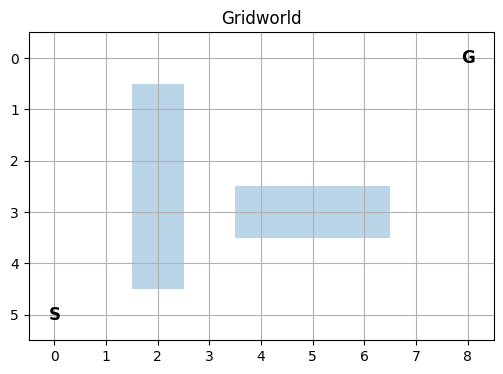

In [9]:

import numpy as np
import matplotlib.pyplot as plt

# Re-seed for repeatability
RNG = np.random.default_rng(42)

# Actions: 0:Up, 1:Right, 2:Down, 3:Left
ACTIONS = np.array([[ -1, 0],  # Up
                    [  0, 1],  # Right
                    [  1, 0],  # Down
                    [  0,-1]]) # Left
ACTION_NAMES = ["↑","→","↓","←"]

# Grid definition
n_rows, n_cols = 6, 9
START = (5, 0)
GOAL  = (0, 8)

# Obstacles (impassable cells)
OBSTACLES = {(1,2),(2,2),(3,2),(4,2),  # vertical wall
             (3,4),(3,5),(3,6)}        # horizontal wall

STEP_REWARD = -1.0
OBST_REWARD = -5.0
GOAL_REWARD = 10.0

def in_bounds(r, c):
    return 0 <= r < n_rows and 0 <= c < n_cols

def step(state, action):
    # Environment transition.
    # Args:
    #   state: (r,c)
    #   action: int in {0,1,2,3}
    # Returns:
    #   next_state: (r',c')
    #   reward: float
    #   done: bool
    r, c = state
    dr, dc = ACTIONS[action]
    nr, nc = r + dr, c + dc

    # if move goes out of bounds, stay
    if not in_bounds(nr, nc):
        nr, nc = r, c

    # if hits obstacle, penalize & stay
    if (nr, nc) in OBSTACLES:
        reward = OBST_REWARD
        nr, nc = r, c  # bump into wall: stay
    elif (nr, nc) == GOAL:
        reward = GOAL_REWARD
    else:
        reward = STEP_REWARD

    done = (nr, nc) == GOAL
    return (nr, nc), reward, done

def render_grid(ax=None, title="Gridworld"):
    # Plot the grid with obstacles, start, and goal.
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title(title)
    ax.set_xlim(-0.5, n_cols-0.5)
    ax.set_ylim(-0.5, n_rows-0.5)
    ax.set_xticks(range(n_cols))
    ax.set_yticks(range(n_rows))
    ax.grid(True)

    # Draw obstacles
    for (r,c) in OBSTACLES:
        ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, fill=True, alpha=0.3))

    # Start & Goal
    ax.text(START[1], START[0], "S", ha="center", va="center", fontsize=12, fontweight="bold")
    ax.text(GOAL[1],  GOAL[0],  "G", ha="center", va="center", fontsize=12, fontweight="bold")

    ax.invert_yaxis()
    return ax

render_grid()
plt.show()



## 4. Q‑Learning Training

**What this cell does:**  
- Implements the **ε‑greedy** action selection and the **Q‑Learning update**.  
- Trains over multiple episodes; tracks episode returns and lengths.  
- Decays ε to transition from exploration to exploitation.

**Key parameters & why:**  
- `alpha (α)` – learning rate (how much new information overrides old): typically `0.1–0.7`.  
- `gamma (γ)` – discount factor (value future rewards): `0.90–0.99` common.  
- `epsilon (ε)` – exploration rate to try sub‑optimal actions early.  
- `epsilon_decay` – multiplicative decay each episode.  
- `episodes` – more episodes → better convergence (to a point).

**Loop details (1 episode):**  
1. Reset to `START`.  
2. Pick actions via ε‑greedy from Q.  
3. Apply environment `step`, get `s'`, `r`, `done`.  
4. Update `Q[s,a] ← Q[s,a] + α(r + γ max_a' Q[s',a'] − Q[s,a])`.  
5. Move to `s'`; stop if `done`.


In [10]:

# Hyper-parameters
alpha = 0.5
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
episodes = 1500
max_steps = 200

# Q-table: shape (n_rows, n_cols, n_actions)
Q = np.zeros((n_rows, n_cols, 4), dtype=float)

def epsilon_greedy_action(state):
    r, c = state
    if RNG.random() < epsilon:
        return RNG.integers(0, 4)
    # tie-break randomly among best actions
    qvals = Q[r, c]
    maxq = qvals.max()
    best = np.flatnonzero(qvals == maxq)
    return RNG.choice(best)

returns = []
lengths = []

for ep in range(episodes):
    state = START
    ep_return = 0.0
    steps = 0

    for t in range(max_steps):
        a = epsilon_greedy_action(state)
        ns, r, done = step(state, a)

        # Q-learning update
        r0, c0 = state
        r1, c1 = ns
        td_target = r + gamma * Q[r1, c1].max() * (0.0 if done else 1.0)
        td_error  = td_target - Q[r0, c0, a]
        Q[r0, c0, a] += alpha * td_error

        state = ns
        ep_return += r
        steps += 1
        if done:
            break

    # decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    returns.append(ep_return)
    lengths.append(steps)

print("Training complete.")
print(f"Final epsilon: {epsilon:.3f}")
print("Average return (last 100 eps):", float(np.mean(returns[-100:])))
print("Average steps  (last 100 eps):", float(np.mean(lengths[-100:])))


Training complete.
Final epsilon: 0.050
Average return (last 100 eps): -2.87
Average steps  (last 100 eps): 13.75



## 5. Training Curves & Learned Policy

**This section:**  
- Plots episode returns / lengths (learning progress).  
- Derives a **greedy policy** from the final Q‑table.  
- Visualises arrows for the best action in each reachable cell.


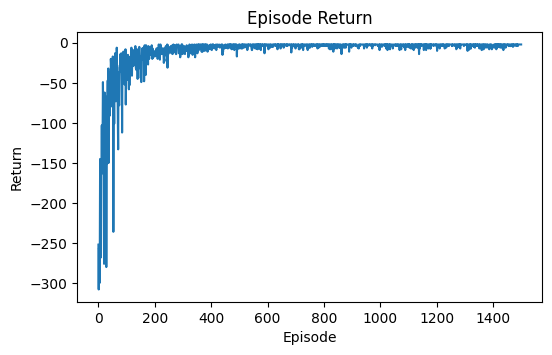

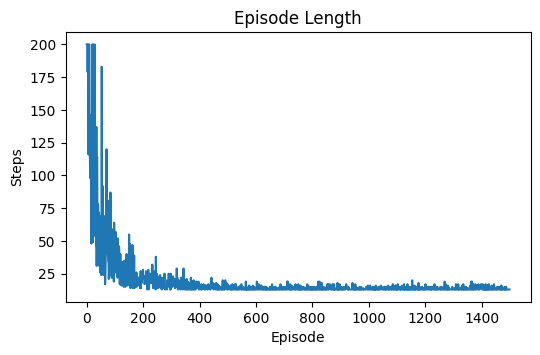

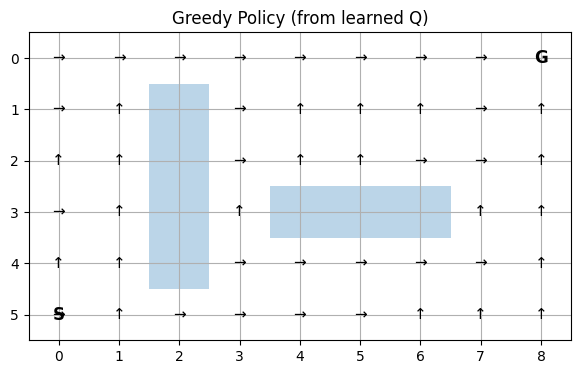

In [11]:

# Plot learning curves
fig1, ax1 = plt.subplots(figsize=(6,3.5))
ax1.plot(returns)
ax1.set_title("Episode Return")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Return")
plt.show()

fig2, ax2 = plt.subplots(figsize=(6,3.5))
ax2.plot(lengths)
ax2.set_title("Episode Length")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Steps")
plt.show()

# Greedy policy arrows
ACTION_NAMES = ["↑","→","↓","←"]
policy = np.full((n_rows, n_cols), -1, dtype=int)
for r in range(n_rows):
    for c in range(n_cols):
        if (r,c) in OBSTACLES or (r,c) == GOAL:
            continue
        q = Q[r,c]
        best = np.flatnonzero(q == q.max())
        policy[r,c] = np.random.choice(best)

fig, ax = plt.subplots(figsize=(7,4))
render_grid(ax, "Greedy Policy (from learned Q)")
for r in range(n_rows):
    for c in range(n_cols):
        if (r,c) in OBSTACLES or (r,c) == GOAL:
            continue
        a = policy[r,c]
        if a >= 0:
            ax.text(c, r, ACTION_NAMES[a], ha="center", va="center", fontsize=11)
plt.show()



## 6. Policy Evaluation: Greedy Rollout

We now **roll out** the greedy policy from `START` to estimate performance.  
Metrics shown: steps to goal, cumulative reward.

**Function of interest:** `run_greedy_episode()`  
- **Input:** Q‑table, env functions.  
- **Output:** path, total reward, steps, and whether the agent reached the goal.


Success: True | Steps: 13 | Total reward: -2.0


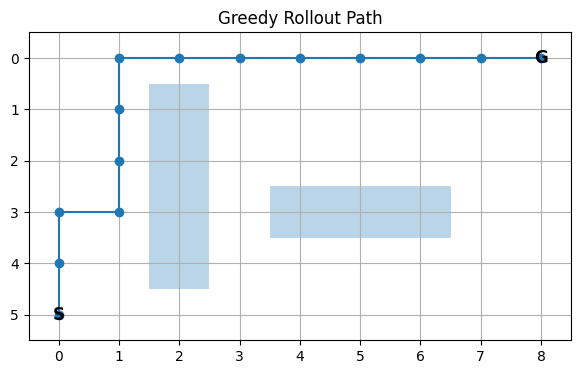

In [12]:

def run_greedy_episode(max_steps=200):
    path = [START]
    total = 0.0
    state = START
    for t in range(max_steps):
        r, c = state
        a = int(np.argmax(Q[r,c]))
        ns, rew, done = step(state, a)
        total += rew
        path.append(ns)
        state = ns
        if done:
            return path, total, t+1, True
    return path, total, max_steps, False

path, total_reward, steps, success = run_greedy_episode()
print("Success:", success, "| Steps:", steps, "| Total reward:", total_reward)

# Visualise path
fig, ax = plt.subplots(figsize=(7,4))
render_grid(ax, "Greedy Rollout Path")
xs = [c for (r,c) in path]
ys = [r for (r,c) in path]
ax.plot(xs, ys, marker="o")
plt.show()
